In [18]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import multiprocessing as mp
import tqdm
from functools import partial

from specsens import util
from specsens import util_sim
from specsens import WirelessMicrophone
from specsens import WhiteGaussianNoise
from specsens import WidebandEnergyDetector
from specsens import Stft
from specsens import est_stats


def generation(f_sample, length_sec, itrs, noise_power, signal_power,
               noise_uncert, threshold, window, fft_len, num_bands, f_center,
               band_to_detect, band_noise_est, noise_est_hist, seeds):

    # create new signal objects
    wm = WirelessMicrophone(f_sample=f_sample, t_sec=length_sec, seed=seeds[0])
    wgn = WhiteGaussianNoise(f_sample=f_sample,
                             t_sec=length_sec,
                             seed=seeds[1])

    # local rng
    rng = np.random.default_rng(seeds[2])

    # calculate noise power with uncertainty
    gen_noise_power = rng.normal(loc=noise_power, scale=noise_uncert)

#     # noise estimation
    wm_est = WirelessMicrophone(f_sample=f_sample,
                                t_sec=length_sec * noise_est_hist,
                                seed=seeds[0])
    wgn_est = WhiteGaussianNoise(f_sample=f_sample,
                                 t_sec=length_sec * noise_est_hist,
                                 seed=seeds[1])
    sig_est = wm.soft(f_center=f_center, power=signal_power, dB=True)
    noise_est = wgn.signal(power=gen_noise_power, dB=True)
    both_est = sig_est + noise_est
    mean, fit_hist, fit_kde, mle = ss.noise_est.estimate(both_est, int(f_sample * length_sec), l=50)
#     print('Actual:   %.4f dB' % (noise_power))
#     print('Mean:     %.4f dB  err: %.4f dB' %
#       (mean, ss.util.dB_rel_err(noise_power, mean)))
#     print('Fit hist: %.4f dB  err: %.4f dB' %
#       (fit_hist, ss.util.dB_rel_err(noise_power, fit_hist)))
#     print('Fit KDE:  %.4f dB  err: %.4f dB' %
#       (fit_kde, ss.util.dB_rel_err(noise_power, fit_kde)))
#     print('MLE:      %.4f dB  err: %.4f dB' % (mle, ss.util.dB_rel_err(noise_power, mle)))
    noise_estimate = util.dB_to_factor_power(fit_kde)

    # store results in 'result' array energies in 'energy' array
    result = np.array([])
    energy = np.array([])

    # list for noise estimation
    noise_est_list = np.array([])

    # list for noise estimation used with hacky histogram fix
    noise_est_list2 = np.array([])

    # 'inner' interations loop
    for _ in range(itrs):

        # generate signal
        sig = wm.soft(f_center=f_center, power=signal_power, dB=True)

        # generate noise
        noise = wgn.signal(power=gen_noise_power, dB=True)

        # randomly decide whether signal should be present
        sig_present = rng.choice([True, False])
        if sig_present:
            both = sig + noise
        else:
            both = noise

        # create a Short Time Fourier Transform object
        sft = Stft(n=fft_len, window=window)

        # use the stft to transform the signal into the frequency domain
        f, psd = sft.stft(both, f_sample, normalized=False, dB=False)

        # create a Wideband Energy Detector object
        fed = WidebandEnergyDetector(num_bands=num_bands,
                                     f_sample=f_sample,
                                     fft_len=fft_len,
                                     freqs=f)

        # compute energy for all bands
        bands = fed.detect(psd)

        # compute noise power from 'free' band
        noise_est = bands[band_noise_est] / (fft_len / num_bands)


        # handle size of noise estimation list
        if np.size(noise_est_list) >= noise_est_hist:
            noise_est_list = np.delete(noise_est_list, 0)
        noise_est_list = np.append(noise_est_list, noise_est)

        # get noise estimate from noise estimation list
#         noise_estimate = np.mean(noise_est_list)

        # energy detector
        eng = bands[band_to_detect]
        
        # remove noise dependency and normalize
        eng /= noise_estimate * (fft_len / num_bands)

        # threshold
        sig_detected = eng > threshold

        # --- very hacky ---
        # compensation for nonlinearity in energy distributions
        # this just influences / fixes the signal present histogram
        noise2 = wgn.signal(power=noise_power, dB=True)
        both2 = sig + noise2
        f2, psd2 = sft.stft(both2, f_sample, normalized=False, dB=False)
        bands2 = fed.detect(psd2)
        noise_est2 = bands2[band_noise_est] / (fft_len / num_bands)
        if np.size(noise_est_list2) >= noise_est_hist:
            noise_est_list2 = np.delete(noise_est_list2, 0)
        noise_est_list2 = np.append(noise_est_list2, noise_est2)
        if sig_present:
            noise_estimate2 = np.mean(noise_est_list2)
            eng2 = bands2[band_to_detect]
            eng2 /= noise_estimate2 * (fft_len / num_bands)
            eng = eng2
        # --- hacky part end ---

        # log detection outcome
        if sig_present and sig_detected:
            result = np.append(result, 1)
        elif sig_present and not sig_detected:
            result = np.append(result, 2)
        elif not sig_present and sig_detected:
            result = np.append(result, 3)
        else:
            result = np.append(result, 4)

        # log energy
        energy = np.append(energy, eng)

    # calculate statistics and store in arrays
    pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) + np.sum(result == 4))
    pd_tmp = np.sum(result == 1) / (np.sum(result == 1) + np.sum(result == 2))

    return pfa_tmp, pd_tmp, energy, result, gen_noise_power


def estimation_sim(
    gens=50,  # generations, number of environments
    itrs=300,  # iterations, number of tests in each environment
    f_sample=1e6,  # in Hz
    signal_power=0.,  # in dB
    f_center=-1e5,  # signal center frequency
    noise_power=0.,  # in dB
    length_sec=None,  # length of each section in seconds
    num_samples=None,  # number of samples
    theo_pfa=0.1,  # probability of false alarm
    threshold=None,  # threshold used for detection
    noise_uncert=0.0,  # standard deviation of the noise normal distribution
    seed=None,  # random seed used for rng
    num_procs=None,  # number of processes to run in parallel
    window='box',  # window used with fft
    fft_len=1024,  # samples used for fft
    num_bands=1,  # total number of bands
    band_to_detect=0.,  # band to 'search' for signal in
    band_noise_est=None,  # band to use for noise estimation
    noise_est_hist=1):  # depth of noise estimation buffer

    # set number of processes used
    if num_procs is None:
        num_procs = mp.cpu_count()
    assert num_procs > 0, 'num_procs must be greater than 0'
    assert num_procs <= gens, 'num_procs must be less or equal to gens'

    # check and calculate length (in seconds and number of samples)
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    # calculate threshold
    if threshold is None:
        threshold = est_stats.thr(pfa=theo_pfa,
                                  n=fft_len / num_bands,
                                  m=(fft_len / num_bands) * noise_est_hist)

    print('---- Simulation parameters ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_power))
    print('Sig cent. freq: %.1f Hz' % (f_center))
    print('Noise power:    %.2f dB' % (noise_power))
    print('Noise uncert:   %.2f dB' % (noise_uncert))
    print('SNR:            %.2f dB' % (signal_power - noise_power))
    print('Signal length:  %.6f s' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('FFT length:     %d' % (fft_len))
    print('Num. of bands:  %d' % (num_bands))
    print('Band to detect: %d' % (band_to_detect))
    print('Band noise est: %d' % (band_noise_est))
    print('Est. hist.:     %d' % (noise_est_hist))

    # calculate pd (only needed for prints)
    theo_pd = est_stats.pd(noise_power,
                           signal_power,
                           threshold,
                           n=fft_len / num_bands,
                           m=(fft_len / num_bands) * noise_est_hist,
                           num_bands=num_bands)

    print('---- Simulation stats theory ----')
    print('Prob false alarm: %.4f' % (theo_pfa))
    print('Prob detection:   %.4f' % (theo_pd))
    print('Threshold:        %.4f' % (threshold))

    print('---- Running simulation ----')
    print('Using %d processes on %d cores' % (num_procs, mp.cpu_count()))

    pfas = list()  # probability of false alarm list
    pds = list()  # probability of detection list
    current_time = None  # time variable used for 'runtime_stats'

    # generate child seeds for wm and wgn
    seed_seq = np.random.SeedSequence(seed)
    seeds = list(
        zip(seed_seq.spawn(gens), seed_seq.spawn(gens), seed_seq.spawn(gens)))

    # prepare parallel execution
    p = mp.Pool(processes=num_procs)
    f = partial(generation, f_sample, length_sec, itrs, noise_power,
                signal_power, noise_uncert, threshold, window, fft_len,
                num_bands, f_center, band_to_detect, band_noise_est,
                noise_est_hist)

    # run simulation while showing progress bar
    res = list(tqdm.tqdm(p.imap(f, seeds), total=gens))

    # cleanup parallel execution
    p.close()
    p.join()

    # 'unwrap' res tuples
    pfas = [r[0] for r in res]
    pds = [r[1] for r in res]
    energies = np.ravel([r[2] for r in res])
    results = np.ravel([r[3] for r in res])
    gen_noise_powers = np.ravel([r[4] for r in res])

    # calulate theo_pd again, but take nonlinearity into account
    theo_pd_post = list(
        map(
            lambda x: est_stats.pd(x,
                                   signal_power,
                                   threshold,
                                   n=fft_len / num_bands,
                                   m=(fft_len / num_bands) * noise_est_hist,
                                   num_bands=num_bands), gen_noise_powers))

    # compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    # compute energy distributions
    engs_both = energies[np.where(results <= 2)[0]]
    engs_noise = energies[np.where(results > 2)[0]]

    print('---- Simulation stats ----')
    print('Prob false alarm theory:      %.4f' % (theo_pfa))
    print('Prob false alarm sim:         %.4f' % (pfa))
    print('Prob detection theory (post): %.4f' % (np.mean(theo_pd_post)))
    print('Prob detection sim:           %.4f' % (pd))

    # print the convergence diagrams
    util_sim.print_convergence(gens, pfas, pds, theo_pfa,
                               np.mean(theo_pd_post))

    # print energy distributions
    util_sim.print_distribution(engs_both,
                                engs_noise,
                                fft_len // num_bands,
                                signal_power,
                                noise_power,
                                threshold,
                                num_bands,
                                num_est_samples=(fft_len / num_bands) *
                                noise_est_hist,
                                no_info=False)

    return pfa, pd

---- Simulation parameters ----
Generations:    100
Iterations:     100
Total iters:    10000
Signal power:   0.00 dB
Sig cent. freq: -150000.0 Hz
Noise power:    12.00 dB
Noise uncert:   0.00 dB
SNR:            -12.00 dB
Signal length:  0.001024 s
Signal samples: 1024
FFT length:     1024
Num. of bands:  4
Band to detect: 1
Band noise est: 3
Est. hist.:     10
---- Simulation stats theory ----
Prob false alarm: 0.1000
Prob detection:   0.9799
Threshold:        1.0840
---- Running simulation ----
Using 8 processes on 8 cores


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


---- Simulation stats ----
Prob false alarm theory:      0.1000
Prob false alarm sim:         0.0698
Prob detection theory (post): 0.9799
Prob detection sim:           0.9589


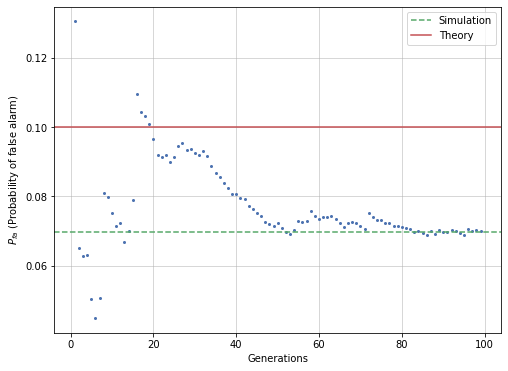

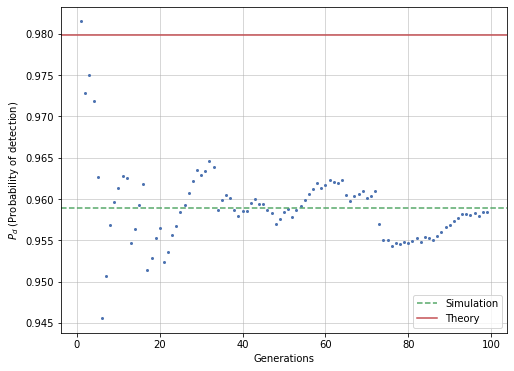

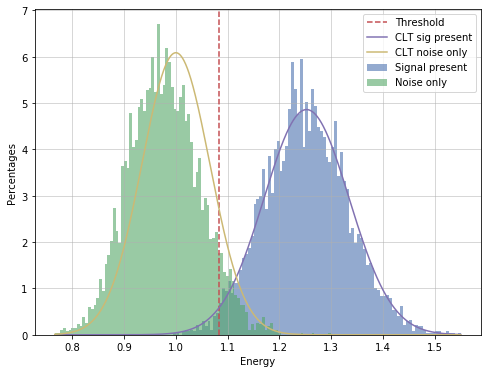

---- Distribution stats ----
Sig present mean: 1.2510
Sig absent  mean: 0.9791
Sig present var:  0.0065
Sig absent  var:  0.0048
Sig present std:  0.0806
Sig absent  std:  0.0690


In [23]:
# wideband band energy detector simulation

_ = estimation_sim(
    gens=100,  # generations, number of environments
    itrs=100,  # iterations, number of tests in each environment
    f_sample=1e6,  # in Hz
    signal_power=0.0,  # in dB
    noise_power=12,  # in dB
    length_sec=0.001024,  # length of each sample in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_uncert=0.0,  # standard deviation of the noise normal distribution in dB
    num_procs=None,  # number of processes to run in parallel
    seed=None,  # set seed for reproducibility
    window='box',  # window used with fft
    fft_len=1024,  # samples used for fft
    num_bands=4,  # total number of bands
    f_center=-1.5e5,  # signal center frequency
    band_to_detect=1,  # band to 'search' for signal in
    band_noise_est=3,  # band to use for noise estimation
    noise_est_hist=10)  # depth of noise estimation buffer

# windows, except for the 'box' (rectangular) window distort the energy distribution
# and result in wrong statistics -> try 'flattop' for example